In [1]:
import pandas as pd

# EXP Smoothing( state level)

In [2]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')

import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']

hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])
quantile_result2['location'] = quantile_result2['location'].astype(str).str.zfill(2)

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Feb 10, 2024)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Regional LSTM

## Generate quantile prediction

In [31]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/allresulttest0207.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [32]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-32-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-32-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-32-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-32-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,01,2024-02-03,0,0.010,39.00
1,01,2024-02-03,0,0.025,42.00
2,01,2024-02-03,0,0.050,44.95
3,01,2024-02-03,0,0.100,47.00
4,01,2024-02-03,0,0.150,49.00
...,...,...,...,...,...
4595,56,2024-02-03,3,0.850,13.00
4596,56,2024-02-03,3,0.900,14.00
4597,56,2024-02-03,3,0.950,16.00
4598,56,2024-02-03,3,0.975,17.00


In [33]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,01,2024-02-10,0,0.010,39.00
1,01,2024-02-10,0,0.025,42.00
2,01,2024-02-10,0,0.050,44.95
3,01,2024-02-10,0,0.100,47.00
4,01,2024-02-10,0,0.150,49.00
...,...,...,...,...,...
4595,56,2024-02-10,3,0.850,13.00
4596,56,2024-02-10,3,0.900,14.00
4597,56,2024-02-10,3,0.950,16.00
4598,56,2024-02-10,3,0.975,17.00


In [34]:
import csv
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv',index = False)
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,39.00
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,42.00
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,44.95
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,47.00
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,49.00
...,...,...,...,...,...,...,...,...
4595,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.850,13.00
4596,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.900,14.00
4597,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.950,16.00
4598,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.975,17.00


## Plot admission at each location

In [35]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-02-03** (training set: after 2022-08)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']

hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Regional LSTM Up and down

## Generate quantile prediction

In [73]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/1allresulttestup0207.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
#pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [74]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-74-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-74-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-74-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-74-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,2,2024-02-03,0,0.010,5.0
1,2,2024-02-03,0,0.025,5.0
2,2,2024-02-03,0,0.050,6.0
3,2,2024-02-03,0,0.100,6.0
4,2,2024-02-03,0,0.150,6.0
...,...,...,...,...,...
1467,56,2024-02-03,3,0.850,8.0
1468,56,2024-02-03,3,0.900,9.0
1469,56,2024-02-03,3,0.950,9.0
1470,56,2024-02-03,3,0.975,10.0


In [75]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,2,2024-02-10,0,0.010,5.0
1,2,2024-02-10,0,0.025,5.0
2,2,2024-02-10,0,0.050,6.0
3,2,2024-02-10,0,0.100,6.0
4,2,2024-02-10,0,0.150,6.0
...,...,...,...,...,...
1467,56,2024-02-10,3,0.850,8.0
1468,56,2024-02-10,3,0.900,9.0
1469,56,2024-02-10,3,0.950,9.0
1470,56,2024-02-10,3,0.975,10.0


In [76]:
import csv
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
#quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv',index = False)
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,02,quantile,0.010,5.0
1,2024-02-10,wk inc flu hosp,0,2024-02-10,02,quantile,0.025,5.0
2,2024-02-10,wk inc flu hosp,0,2024-02-10,02,quantile,0.050,6.0
3,2024-02-10,wk inc flu hosp,0,2024-02-10,02,quantile,0.100,6.0
4,2024-02-10,wk inc flu hosp,0,2024-02-10,02,quantile,0.150,6.0
...,...,...,...,...,...,...,...,...
1467,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.850,8.0
1468,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.900,9.0
1469,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.950,9.0
1470,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.975,10.0


## Plot admission at each location

In [77]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-02-03** (training set: after 2022-08)

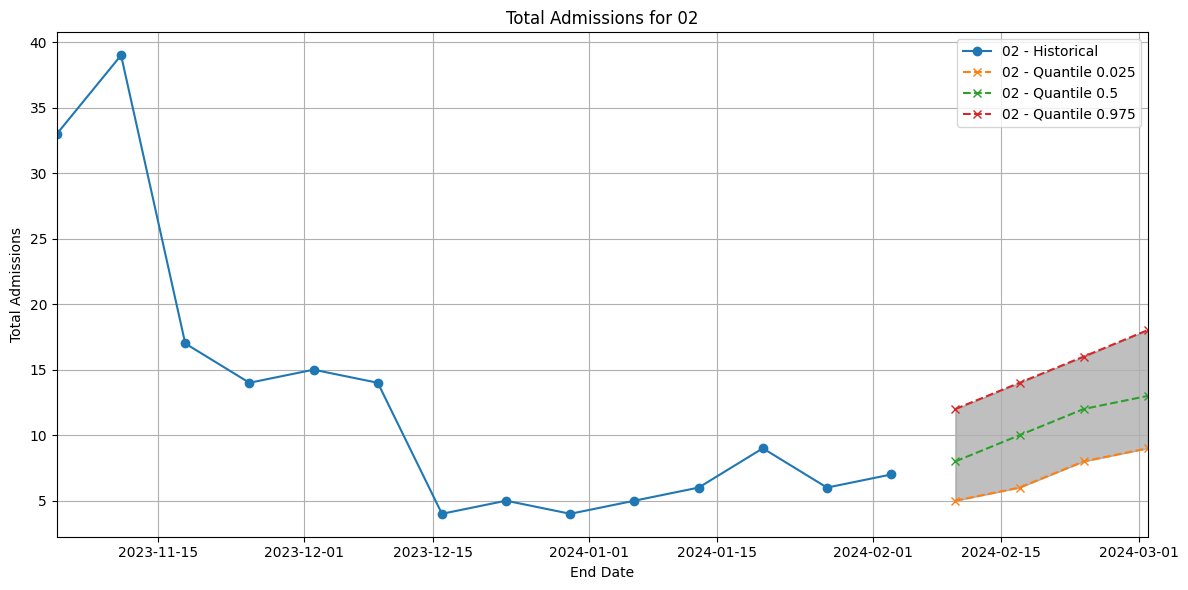

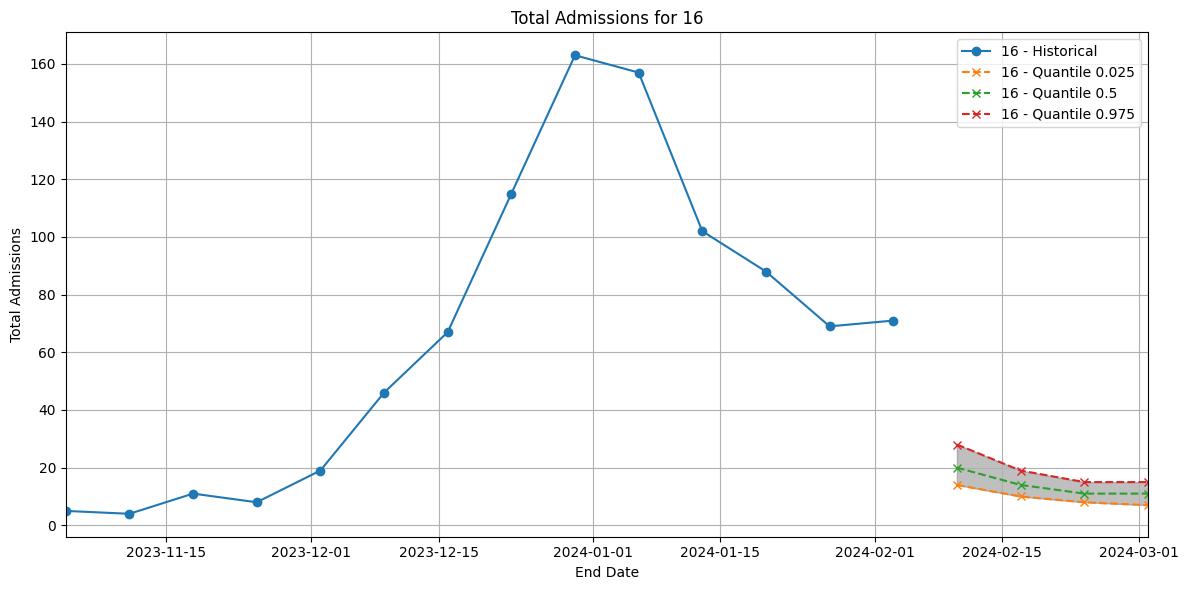

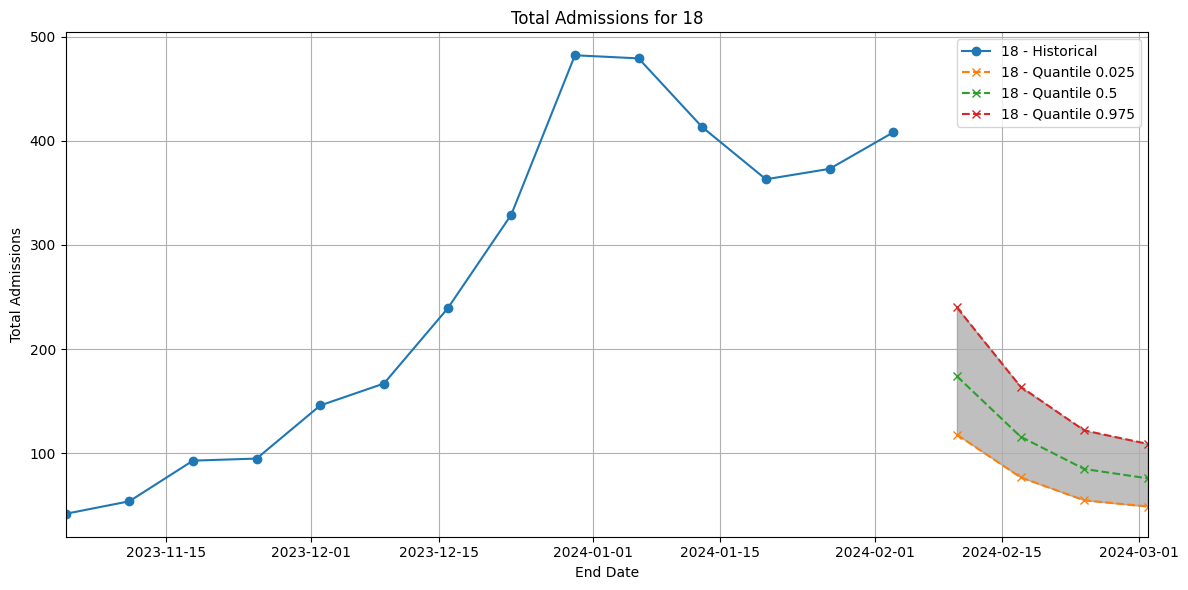

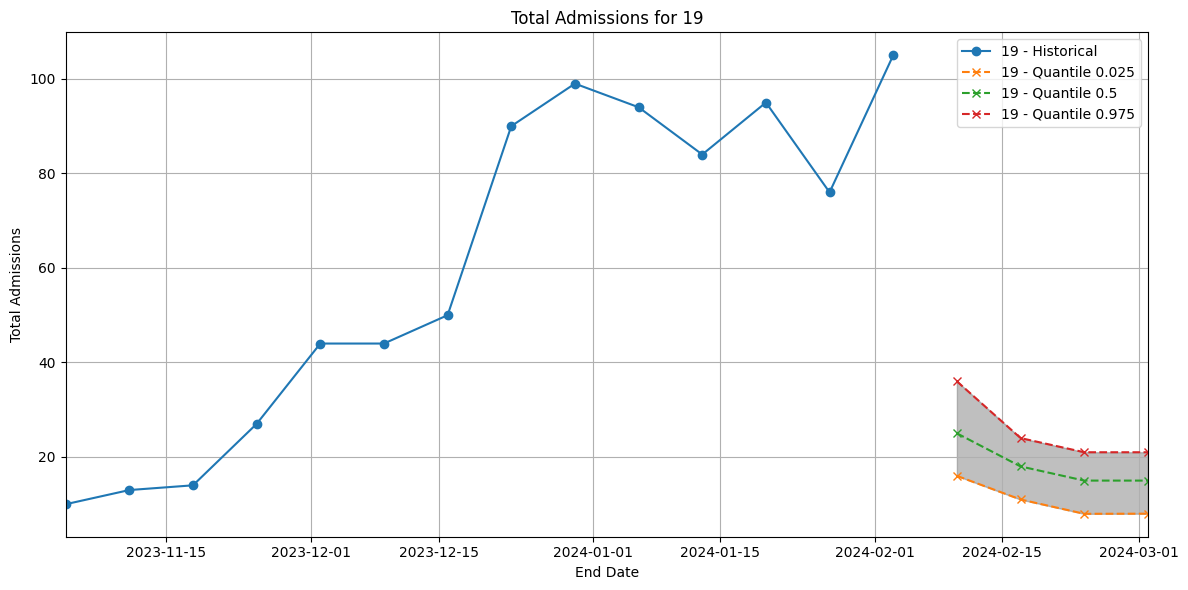

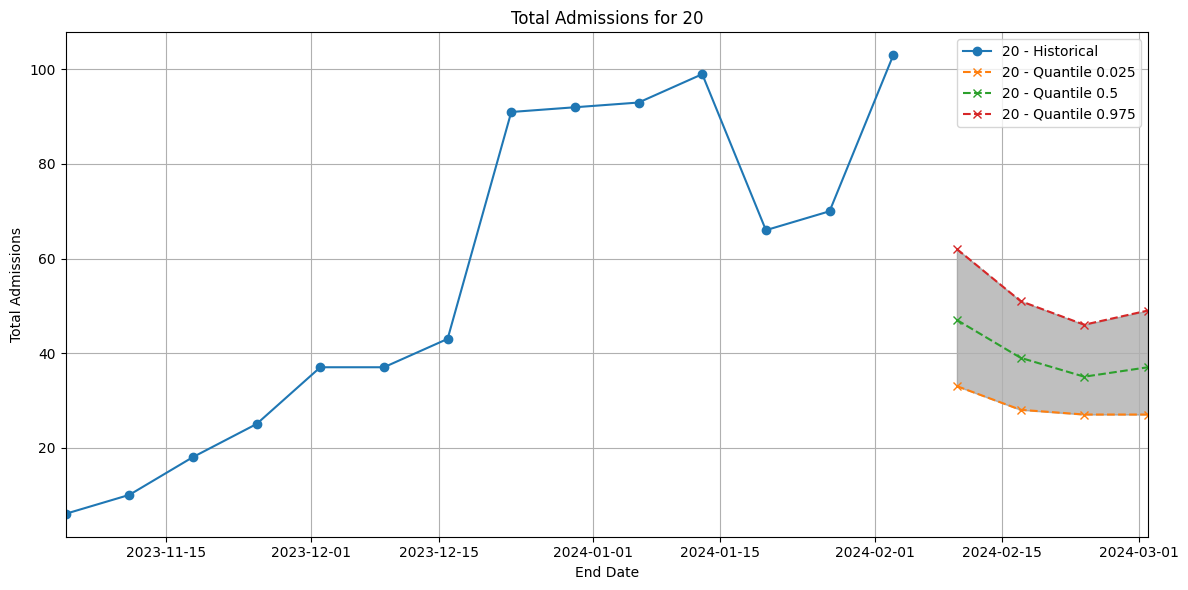

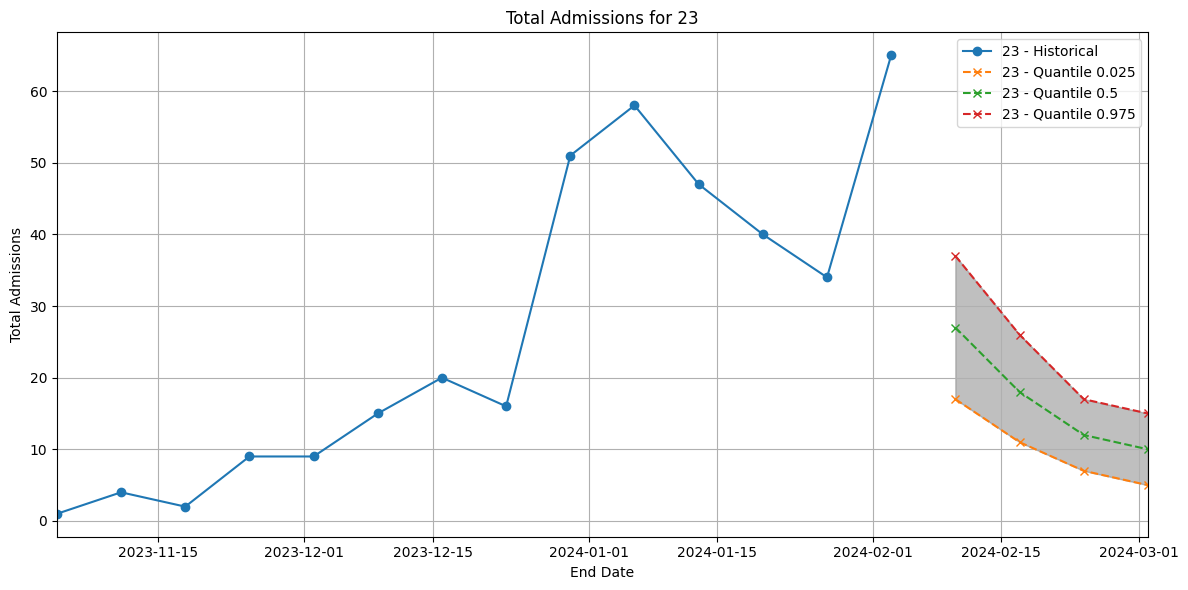

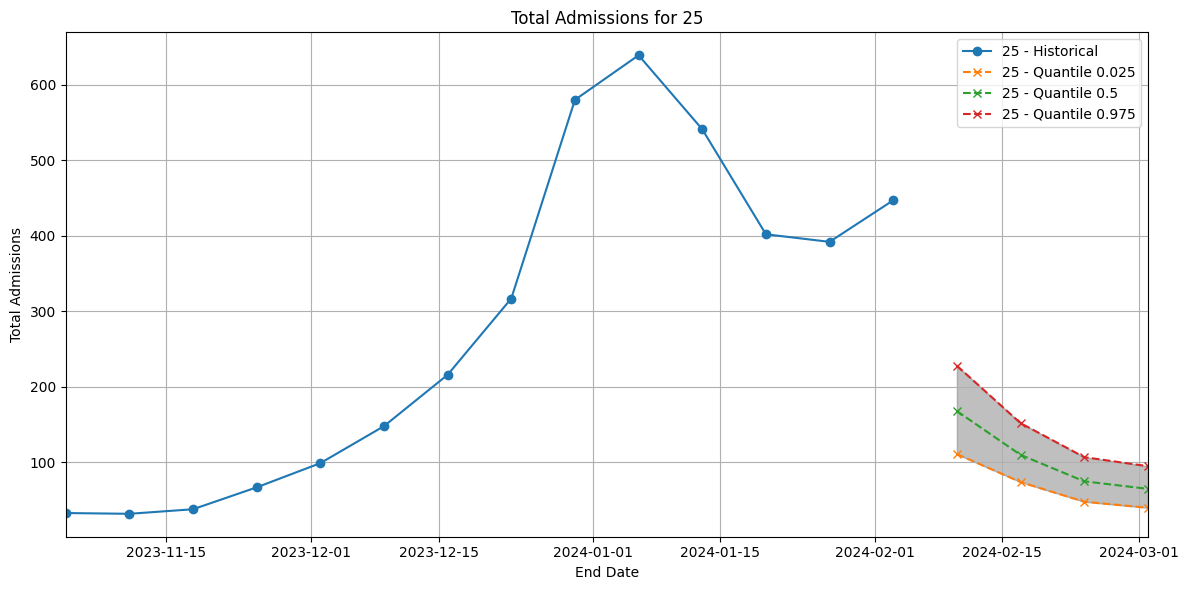

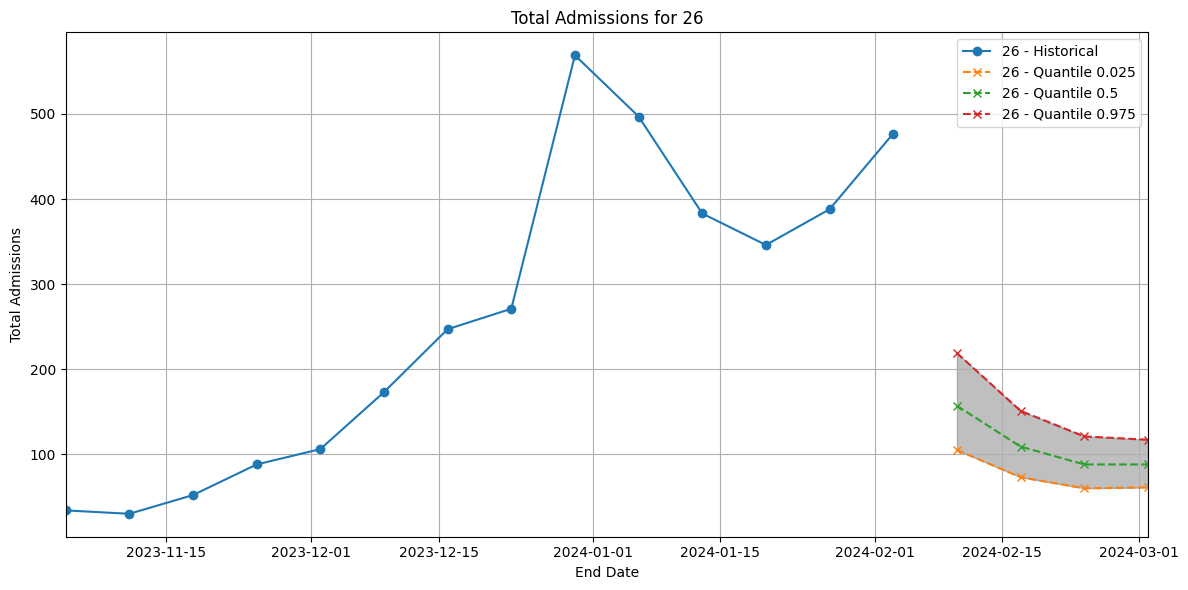

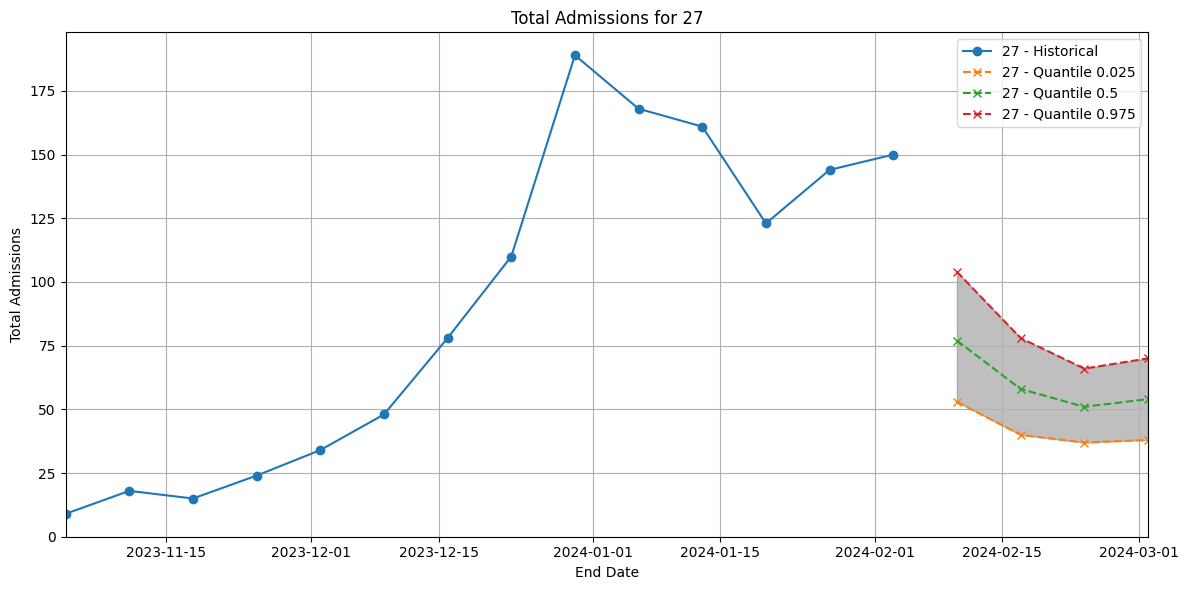

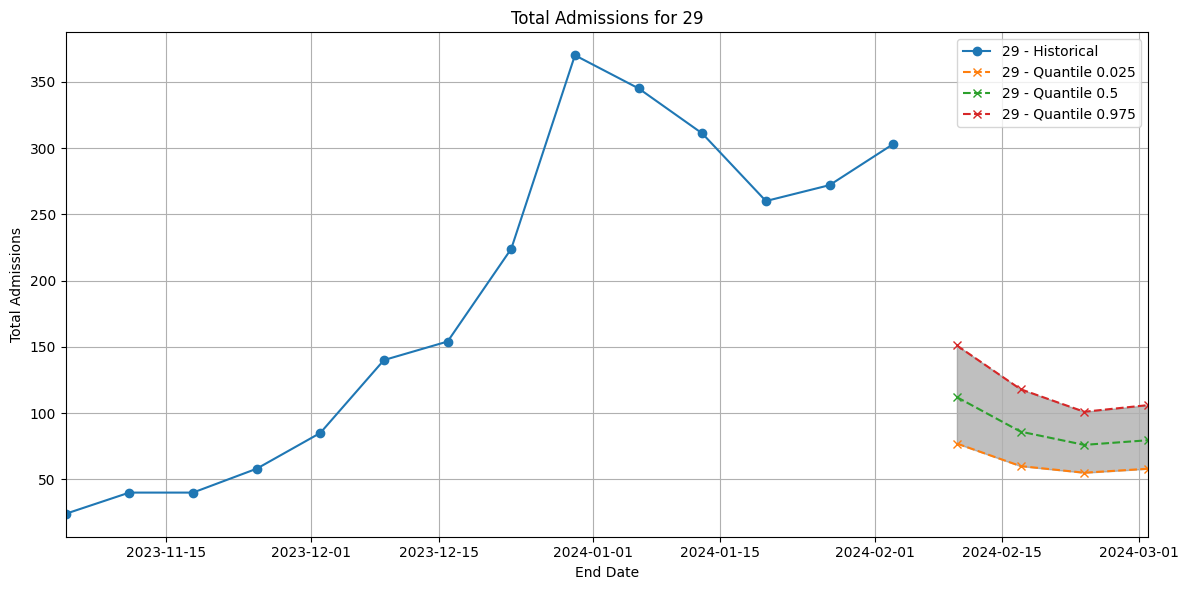

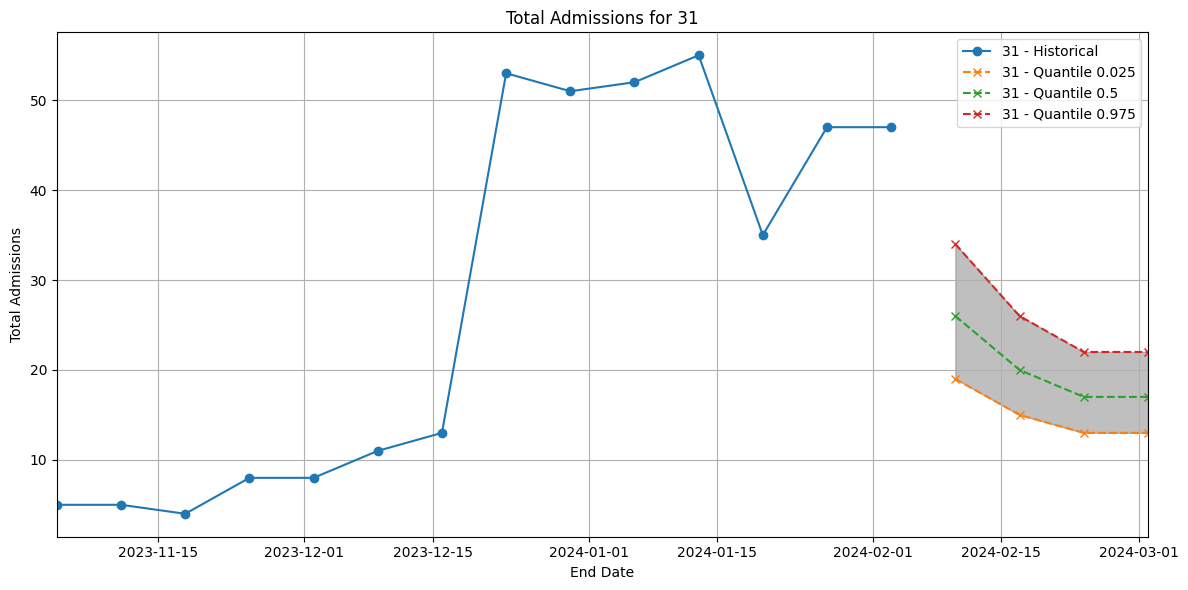

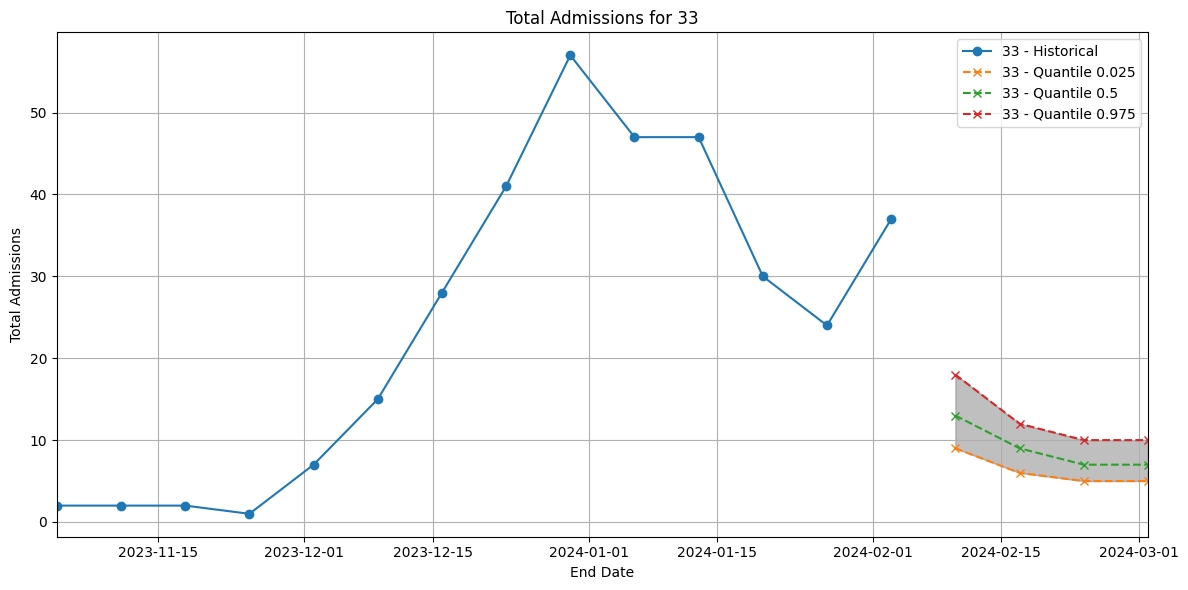

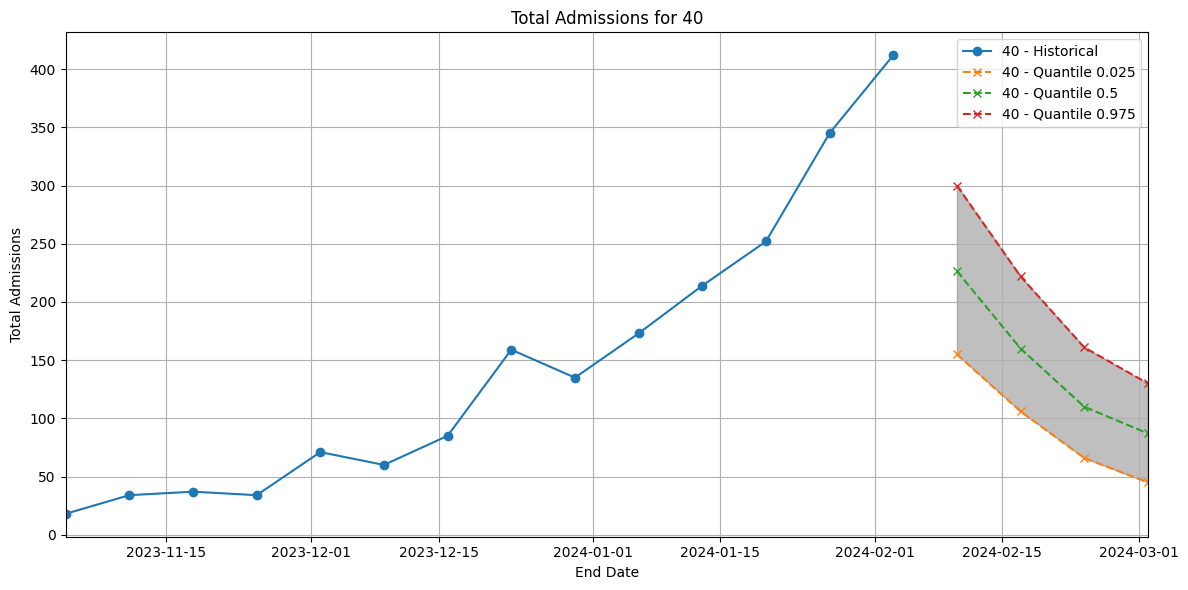

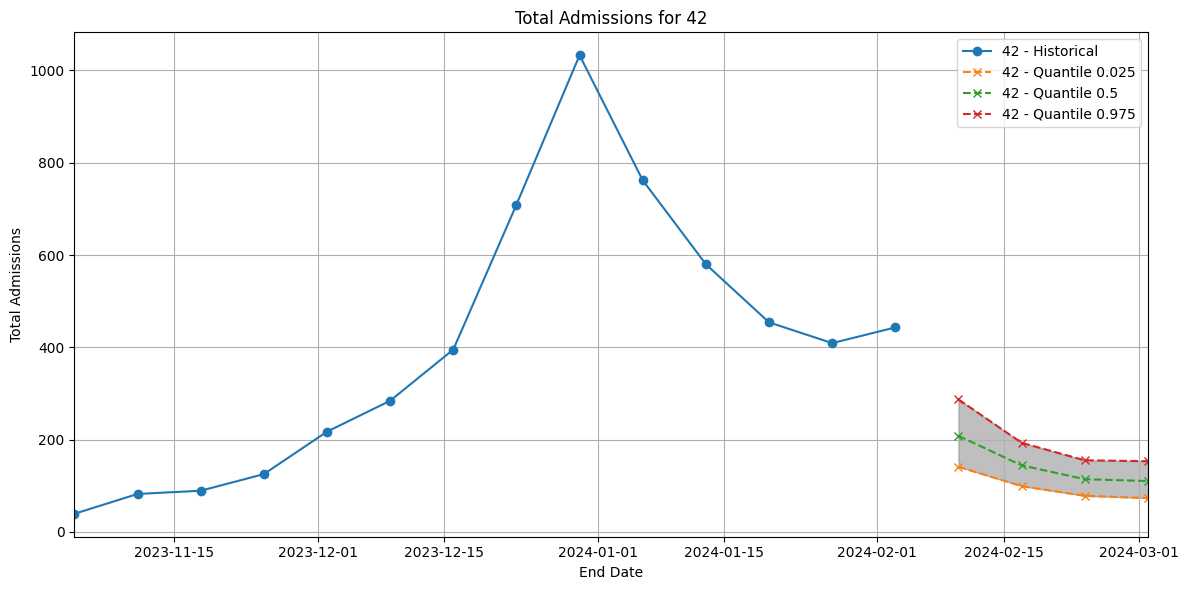

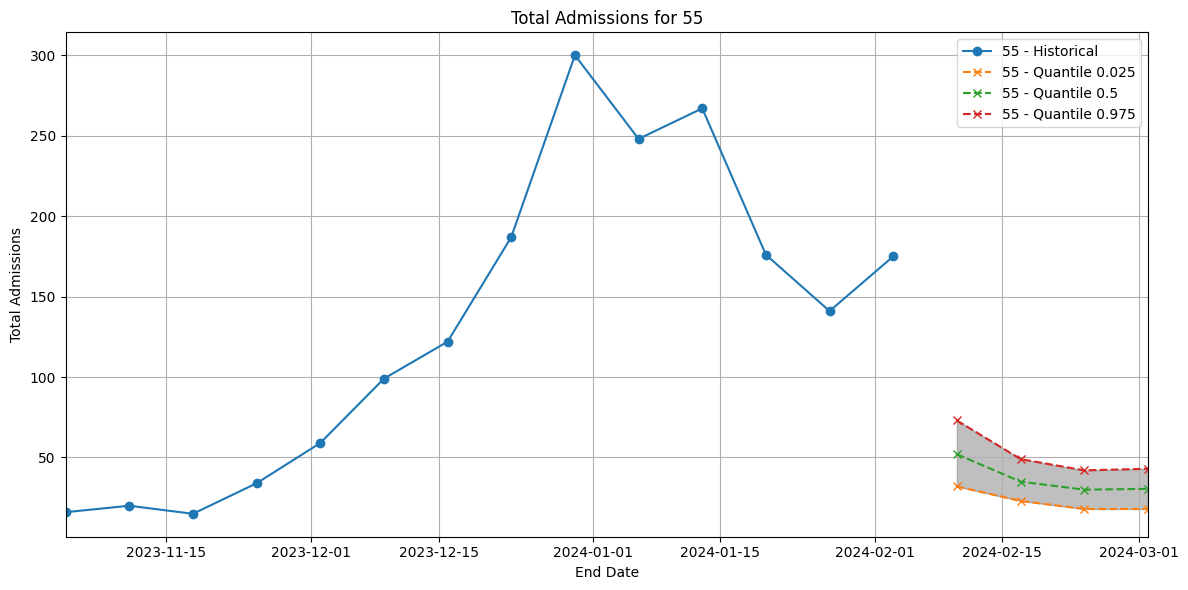

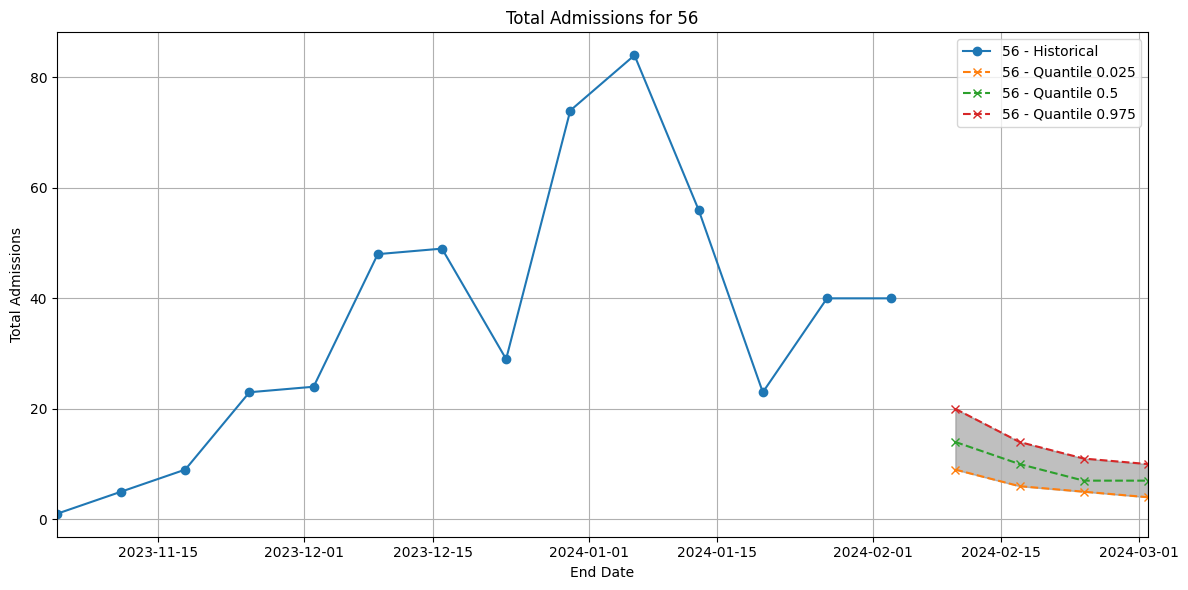

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
#quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']

hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result1['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


# LSTM

## Generate quantile prediction

In [9]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/allresulttest0207.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [10]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-10-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-10-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-10-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-10-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,1,2024-02-03,0,0.010,64.0
1,1,2024-02-03,0,0.025,69.0
2,1,2024-02-03,0,0.050,74.0
3,1,2024-02-03,0,0.100,79.0
4,1,2024-02-03,0,0.150,84.0
...,...,...,...,...,...
4595,56,2024-02-03,3,0.850,26.0
4596,56,2024-02-03,3,0.900,27.0
4597,56,2024-02-03,3,0.950,29.0
4598,56,2024-02-03,3,0.975,30.0


In [11]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,1,2024-02-10,0,0.010,64.0
1,1,2024-02-10,0,0.025,69.0
2,1,2024-02-10,0,0.050,74.0
3,1,2024-02-10,0,0.100,79.0
4,1,2024-02-10,0,0.150,84.0
...,...,...,...,...,...
4595,56,2024-02-10,3,0.850,26.0
4596,56,2024-02-10,3,0.900,27.0
4597,56,2024-02-10,3,0.950,29.0
4598,56,2024-02-10,3,0.975,30.0


In [12]:
import csv
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0207.csv',index = False)
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,64.0
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,69.0
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,74.0
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,79.0
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,84.0
...,...,...,...,...,...,...,...,...
4595,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.850,26.0
4596,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.900,27.0
4597,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.950,29.0
4598,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.975,30.0


## Plot admission at each location

In [13]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-01-27** (training set: after 2022-08)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0207.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### **2024-01-20**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0117.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), quantile_result2['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# GRU

## Generate quantile prediction

In [17]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/allresulttest0207.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [18]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-18-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-18-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-18-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-18-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,1,2024-02-03,0,0.010,28.000
1,1,2024-02-03,0,0.025,34.975
2,1,2024-02-03,0,0.050,40.000
3,1,2024-02-03,0,0.100,45.000
4,1,2024-02-03,0,0.150,49.000
...,...,...,...,...,...
4595,56,2024-02-03,3,0.850,22.000
4596,56,2024-02-03,3,0.900,23.000
4597,56,2024-02-03,3,0.950,25.000
4598,56,2024-02-03,3,0.975,27.000


In [19]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,1,2024-02-10,0,0.010,28.000
1,1,2024-02-10,0,0.025,34.975
2,1,2024-02-10,0,0.050,40.000
3,1,2024-02-10,0,0.100,45.000
4,1,2024-02-10,0,0.150,49.000
...,...,...,...,...,...
4595,56,2024-02-10,3,0.850,22.000
4596,56,2024-02-10,3,0.900,23.000
4597,56,2024-02-10,3,0.950,25.000
4598,56,2024-02-10,3,0.975,27.000


In [20]:
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,28.000
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,34.975
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,40.000
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,45.000
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,49.000
...,...,...,...,...,...,...,...,...
4595,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.850,22.000
4596,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.900,23.000
4597,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.950,25.000
4598,2024-02-10,wk inc flu hosp,3,2024-03-02,56,quantile,0.975,27.000


In [21]:
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0207.csv',index = False)

## Plot admission at each location

In [22]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-01-13** (training set: after 2022-08)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest011.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### **2024-02-03**(training set: after 2023)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0207.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# EXP SMOOTHING + Regional LSTM+ (LSTM+GRU)

In [37]:
import math
def adjust_quantile_ranges_inplace(result_df, location, horizon):

    quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95 + 0.05, 0.05)) + [0.975, 0.99])


    df_copy = result_df.copy()

    df_copy['output_type_id'] = df_copy['output_type_id'].astype(float)

    condition = (df_copy['location'] == location) & (df_copy['horizon'] == horizon)
    median_value = df_copy[(df_copy['output_type_id'] == 0.5) & condition]['value'].iloc[0]


    def adjust_value(row, median_value):
        if row['output_type_id'] != 0.5 and row['condition']:

            distance = row['value'] - median_value
            adjusted_distance = distance * math.sqrt(horizon +1)
            return median_value + adjusted_distance
        else:
            return row['value']


    df_copy['condition'] = condition  # Temporary column to identify rows to adjust
    df_copy['value'] = df_copy.apply(adjust_value, axis=1, args=(median_value,))
    df_copy.drop('condition', axis=1, inplace=True)  # Remove temporary column

    return df_copy

## 2024-02-10 (after 2022-08)

## Ensemble by directly taking the mean

In [38]:
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0207.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0207.csv')
dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0207.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru, quantil_result_state, quantil_result_regional])
result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
result_df
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})

result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
#result_df.loc[result_df['location'] == 49, 'value'] -= 20

result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
us_df = result_df.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'output_type', 'output_type_id'])['value'].sum().reset_index()
us_df['location'] = 'US'
dc_grouped = dc.groupby(['target_end_date', 'output_type_id'])['value'].sum().reset_index()


merged_df = pd.merge(us_df, dc_grouped, on=['target_end_date', 'output_type_id'], how='left')


merged_df['value_y'] = merged_df['value_y'].fillna(0)


merged_df['value'] = merged_df['value_x'] + merged_df['value_y']

merged_df = merged_df.drop(['value_x', 'value_y'], axis=1)
result_df = pd.concat([result_df, merged_df], ignore_index=True)
'''
result_df.loc[result_df['location'] == '06', 'value'] += 100
result_df.loc[result_df['location'] == '19', 'value'] += 10
result_df.loc[result_df['location'] == '16', 'value'] += 12
result_df.loc[result_df['location'] == '26', 'value'] += 50
result_df.loc[result_df['location'] == '44', 'value'] += 6
result_df.loc[result_df['location'] == '40', 'value'] += 20
result_df.loc[result_df['location'] == '49', 'value'] -= 10
result_df.loc[result_df['location'] == '50', 'value'] += 5
result_df.loc[result_df['location'] == '54', 'value'] += 20
result_df.loc[result_df['location'] == 'US', 'value'] += 1000
'''
result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0207result.csv',index = False)
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,52.50000
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,58.24375
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,63.73750
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,69.00000
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,73.50000
...,...,...,...,...,...,...,...,...
4687,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.850,10168.73750
4688,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.900,10928.37500
4689,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.950,12129.43750
4690,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.975,13262.18125


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result2['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## different weight

In [40]:
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0207.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0207.csv')

weights = {
    'quantil_result_state': 0.3,
    'quantile_result_lstm': 0.3,
    'quantil_result_regional': 0.1,
    'quantile_result_gru': 0.3
}

quantil_result_state['value'] *= weights['quantil_result_state']
quantile_result_lstm['value'] *= weights['quantile_result_lstm']
quantil_result_regional['value'] *= weights['quantil_result_regional']
quantile_result_gru['value'] *= weights['quantile_result_gru']

dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0207.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru, quantil_result_state, quantil_result_regional])

hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})

result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].sum().reset_index()
#result_df.loc[result_df['location'] == 49, 'value'] -= 20

result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
us_df = result_df.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'output_type', 'output_type_id'])['value'].sum().reset_index()
us_df['location'] = 'US'
dc_grouped = dc.groupby(['target_end_date', 'output_type_id'])['value'].sum().reset_index()


merged_df = pd.merge(us_df, dc_grouped, on=['target_end_date', 'output_type_id'], how='left')


merged_df['value_y'] = merged_df['value_y'].fillna(0)


merged_df['value'] = merged_df['value_x'] + merged_df['value_y']

merged_df = merged_df.drop(['value_x', 'value_y'], axis=1)
result_df = pd.concat([result_df, merged_df], ignore_index=True)
'''
result_df.loc[result_df['location'] == '06', 'value'] += 100
result_df.loc[result_df['location'] == '19', 'value'] += 10
result_df.loc[result_df['location'] == '16', 'value'] += 12
result_df.loc[result_df['location'] == '26', 'value'] += 50
result_df.loc[result_df['location'] == '44', 'value'] += 6
result_df.loc[result_df['location'] == '40', 'value'] += 20
result_df.loc[result_df['location'] == '49', 'value'] -= 10
result_df.loc[result_df['location'] == '50', 'value'] += 5
result_df.loc[result_df['location'] == '54', 'value'] += 20
result_df.loc[result_df['location'] == 'US', 'value'] += 1000
'''
result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0207result.csv',index = False)
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,55.2000
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,61.4925
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,67.4950
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,73.4000
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,78.4000
...,...,...,...,...,...,...,...,...
4687,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.850,11370.3350
4688,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.900,12228.3700
4689,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.950,13578.2450
4690,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.975,14860.1475


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result2['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## different weight

In [88]:
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0207.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0207.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0207.csv')

weights = {
    'quantil_result_state': 0.2,
    'quantile_result_lstm': 0.4,
    'quantil_result_regional': 0.1,
    'quantile_result_gru': 0.3
}

quantil_result_state['value'] *= weights['quantil_result_state']
quantile_result_lstm['value'] *= weights['quantile_result_lstm']
quantil_result_regional['value'] *= weights['quantil_result_regional']
quantile_result_gru['value'] *= weights['quantile_result_gru']

dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0207.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru, quantil_result_state, quantil_result_regional])

hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})

result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].sum().reset_index()


result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
us_df = result_df.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'output_type', 'output_type_id'])['value'].sum().reset_index()
us_df['location'] = 'US'
dc_grouped = dc.groupby(['target_end_date', 'output_type_id'])['value'].sum().reset_index()


merged_df = pd.merge(us_df, dc_grouped, on=['target_end_date', 'output_type_id'], how='left')


merged_df['value_y'] = merged_df['value_y'].fillna(0)


merged_df['value'] = merged_df['value_x'] + merged_df['value_y']

merged_df = merged_df.drop(['value_x', 'value_y'], axis=1)
result_df = pd.concat([result_df, merged_df], ignore_index=True)
result_df.loc[result_df['location'] == '16', 'value'] += 40
result_df.loc[result_df['location'] == '17', 'value'] += 50
result_df.loc[result_df['location'] == '18', 'value'] += 150
result_df.loc[result_df['location'] == '19', 'value'] += 40
result_df.loc[result_df['location'] == '20', 'value'] += 20
result_df.loc[result_df['location'] == '23', 'value'] += 30
result_df.loc[result_df['location'] == '25', 'value'] += 200
result_df.loc[result_df['location'] == '26', 'value'] += 100
result_df.loc[result_df['location'] == '29', 'value'] += 100
result_df.loc[result_df['location'] == '33', 'value'] += 20
result_df.loc[result_df['location'] == '40', 'value'] += 50
result_df.loc[result_df['location'] == '42', 'value'] += 150
result_df.loc[result_df['location'] == '44', 'value'] -= 5
result_df.loc[result_df['location'] == '55', 'value'] += 100
result_df.loc[result_df['location'] == '56', 'value'] += 10
result_df.loc[(result_df['location'] == '19') & (result_df['horizon'].isin([0, 1])), 'value'] += 10
result_df.loc[(result_df['location'] == '20') & (result_df['horizon'].isin([0, 1])), 'value'] += 20
result_df.loc[(result_df['location'] == '40') & (result_df['horizon'].isin([0, 1])), 'value'] += 50
result_df.loc[(result_df['location'] == '23') & (result_df['horizon'].isin([0])), 'value'] += 10
result_df.loc[(result_df['location'] == '26') & (result_df['horizon'].isin([0])), 'value'] += 100

for i in range(4):
  result_df = adjust_quantile_ranges_inplace(result_df, '23', i)
  result_df = adjust_quantile_ranges_inplace(result_df, '25', i)
  result_df = adjust_quantile_ranges_inplace(result_df, '26', i)
result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0207result.csv',index = False)
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.010,53.7000
1,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.025,59.6925
2,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.050,65.2950
3,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.100,70.8000
4,2024-02-10,wk inc flu hosp,0,2024-02-10,01,quantile,0.150,75.6000
...,...,...,...,...,...,...,...,...
4687,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.850,10697.3000
4688,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.900,11436.0900
4689,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.950,12579.5150
4690,2024-02-10,wk inc flu hosp,3,2024-03-02,US,quantile,0.975,13655.9225


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result2['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## different weight

In [44]:
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0131.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0131.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/9quantileresulttest0131.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/9quantileresulttest0131.csv')

weights = {
    'quantil_result_state': 0.5,
    'quantile_result_lstm': 0.2,
    'quantil_result_regional': 0.2,
    'quantile_result_gru': 0.1
}

quantil_result_state['value'] *= weights['quantil_result_state']
quantile_result_lstm['value'] *= weights['quantile_result_lstm']
quantil_result_regional['value'] *= weights['quantil_result_regional']
quantile_result_gru['value'] *= weights['quantile_result_gru']

dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0131.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru, quantil_result_state, quantil_result_regional])

hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})

result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].sum().reset_index()
#result_df.loc[result_df['location'] == 49, 'value'] -= 20

result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])


result_df.loc[result_df['location'] == '21', 'value'] += 50
result_df.loc[result_df['location'] == '25', 'value'] += 50
result_df.loc[result_df['location'] == '26', 'value'] += 50
result_df.loc[result_df['location'] == '29', 'value'] += 50
result_df.loc[result_df['location'] == '40', 'value'] += 50
result_df.loc[result_df['location'] == '09', 'value'] += 40
result_df.loc[result_df['location'] == '36', 'value'] += 200
result_df.loc[result_df['location'] == '06', 'value'] -= 100
result_df.loc[result_df['location'] == '31', 'value'] += 10
for i in range(4):
  result_df = adjust_quantile_ranges_inplace(result_df, '06', i)
  result_df = adjust_quantile_ranges_inplace(result_df, '36', i)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
us_df = result_df.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'output_type', 'output_type_id'])['value'].sum().reset_index()
us_df['location'] = 'US'
dc_grouped = dc.groupby(['target_end_date', 'output_type_id'])['value'].sum().reset_index()


merged_df = pd.merge(us_df, dc_grouped, on=['target_end_date', 'output_type_id'], how='left')


merged_df['value_y'] = merged_df['value_y'].fillna(0)


merged_df['value'] = merged_df['value_x'] + merged_df['value_y']

merged_df = merged_df.drop(['value_x', 'value_y'], axis=1)
result_df = pd.concat([result_df, merged_df], ignore_index=True)


result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0131result.csv',index = False)
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-02-03,wk inc flu hosp,0,2024-02-03,01,quantile,0.010,70.7000
1,2024-02-03,wk inc flu hosp,0,2024-02-03,01,quantile,0.025,78.1000
2,2024-02-03,wk inc flu hosp,0,2024-02-03,01,quantile,0.050,84.0000
3,2024-02-03,wk inc flu hosp,0,2024-02-03,01,quantile,0.100,92.3000
4,2024-02-03,wk inc flu hosp,0,2024-02-03,01,quantile,0.150,98.2000
...,...,...,...,...,...,...,...,...
4687,2024-02-03,wk inc flu hosp,3,2024-02-24,US,quantile,0.850,10816.5500
4688,2024-02-03,wk inc flu hosp,3,2024-02-24,US,quantile,0.900,11716.6500
4689,2024-02-03,wk inc flu hosp,3,2024-02-24,US,quantile,0.950,13138.9400
4690,2024-02-03,wk inc flu hosp,3,2024-02-24,US,quantile,0.975,14486.8625


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
result_df = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/0131result.csv')
result_df['location'] = result_df['location'].astype(str).str.zfill(2)
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-03']
quantile_result2
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')

hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result2['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for State {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.010,77.75000
1,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.025,85.74375
2,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.050,92.50000
3,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.100,101.25000
4,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.150,107.75000
...,...,...,...,...,...,...,...,...
4687,2024-01-27,wk inc flu hosp,3,2024-02-17,US,quantile,0.850,8321.17500
4688,2024-01-27,wk inc flu hosp,3,2024-02-17,US,quantile,0.900,8849.55000
4689,2024-01-27,wk inc flu hosp,3,2024-02-17,US,quantile,0.950,9690.12500
4690,2024-01-27,wk inc flu hosp,3,2024-02-17,US,quantile,0.975,10466.16875
